# Numpy

[Numpy](https://www.numpy.org/) is the foundation of most of what you will do with scientific python. Modules like [scipy](https://www.scipy.org/), [pandas](https://pandas.pydata.org/) and [scikit-learn](https://scikit-learn.org/stable/) are built on top of numpy. It is the _linga franca_ for numerical work in python.

In [1]:
import numpy as np

When you are first introduced to Python, one of the big selling points is that it isn't statically typed (dynamic/strong). You can do things like

In [2]:
a = 1
a = 'apple'
print(a)

apple


And you won't get complaints from python about a being an integer. This is a _big_ advantage for python, and it works with collections as well

In [3]:
myList = [1, 3., 'Ian', [range(3)], {'not': 'a good idea'}, lambda x: x**2, object ]
myList

[1,
 3.0,
 'Ian',
 [range(0, 3)],
 {'not': 'a good idea'},
 <function __main__.<lambda>(x)>,
 object]

Lists in python are about as general as they could be. This is very flexible and it lets you do some fancy things, but it has a price. The Python interpreter can't make any assumptions about what will come next in a list; everything has to be treated as a generic object. Python does a good job of hiding the complexity of doing this, but as the lists get longer and more complex the overhead gets larger, and eventually perfomance becomes unacceptable.

One solution to this is to use a statically typed language like C[<sup>1</sup>](#fn1 "footnote and tooltip 1"). There, the burden of dealing with object types is left to the programmer, but that up front cost means programs can be much more efficient operating on them. A good example would be an array of `double`s. In memory, these will be allocated contiguously so when you need to jump to the 1402th double, you can do it with very simple arithmetic. A default python list has a much harder time because the memory allocated for your list could be a horrible mixture of all the different things you've stuffed in there (actually it'll be a collection of pointers to Python objects, each of which will have it's own type information). You could try python [arrays](https://docs.python.org/3/library/array.html), which restrict the items to be of the same time, but numpy offers an even richer experience, with lots of convenience methods and attributes to operate on numerical arrays.

## The `ndarray`

Numpy attempts to keep the advantages of Python without sacrificing the speed of static typing by adding the concept of homogeneous collections to python: `ndarray`s. The `ndarray` is the foundational concept in numpy, it is an array object which represents a multidimensional, homogeneous array of fixed-size items and most commonly these items will be numbers.

In [4]:
%%timeit
for i in range(1000000):
    i*i

46 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%timeit np.arange(1000000)**2

4.46 ms ± 245 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`ndarray`s look like python lists, but they are fundamentally different, e.g.

In [6]:
a = [1, 2, 3, 4]
b = [5, 6, 7, 8]
a+b

[1, 2, 3, 4, 5, 6, 7, 8]

In [7]:
na = np.array([1, 2, 3, 4])
nb = np.array([5, 6, 7, 8])
na + nb

array([ 6,  8, 10, 12])

`numpy` was able to assume that the things in the `ndarray` were the compatible types and vectorize the addition, if we want the same thing with python lists, you'll usually need explicit loops

In [8]:
[ i + j for i, j in zip(a, b) ] 

[6, 8, 10, 12]

_If you dig deep enough in some of the numpy/scipy code you will find that the actual instructions you are executing were compiled from fortran and C. In general you can pass things quite easily between existing libraries and python, but fortran and C use different storage orders for multi-dimensional arrays so you have to be a little bit careful (see ndarray.flags)_

Let's take a look at what actually makes up an `ndarray`.

In [9]:
na = np.array([1,2,3,4,5])
na

array([1, 2, 3, 4, 5])

In [10]:
attr_names = [
    attr_name for attr_name in dir(np.ndarray)
    if not callable(getattr(np.ndarray, attr_name)) 
    and not attr_name[:2] == '__'
]

attr_help = {a : getattr(np.ndarray, a).__doc__.split('\n')[0] for a in attr_names}

In [13]:
attr_help

{'T': 'View of the transposed array.',
 'base': 'Base object if memory is from some other object.',
 'ctypes': 'An object to simplify the interaction of the array with the ctypes',
 'data': "Python buffer object pointing to the start of the array's data.",
 'dtype': "Data-type of the array's elements.",
 'flags': 'Information about the memory layout of the array.',
 'flat': 'A 1-D iterator over the array.',
 'imag': 'The imaginary part of the array.',
 'itemsize': 'Length of one array element in bytes.',
 'nbytes': 'Total bytes consumed by the elements of the array.',
 'ndim': 'Number of array dimensions.',
 'real': 'The real part of the array.',
 'shape': 'Tuple of array dimensions.',
 'size': 'Number of elements in the array.',
 'strides': 'Tuple of bytes to step in each dimension when traversing an array.'}

Using these attributes, numpy can use some of the same tricks that statically typed languges use because the Python interpreter can now infer the memory layout.

In [17]:
a = np.arange(10, dtype=float)
a.nbytes

80

These attributes allow us to look at the same object in memory in multiple ways. `numpy` calls this concept a `view` of the original `ndarray`. Wherever possible, numpy will always try to use views rather than copying data. This is important to numpy's efficiency, but you have to remember that modifications on a view will generally alter the underlying data and so affect all views,

In [19]:
b = a[::2]
b.base is a

True

In [20]:
c = a.reshape(5,2)
c[3, 0] = -1
c.base is a

True

In [21]:
a

array([ 0.,  1.,  2.,  3.,  4.,  5., -1.,  7.,  8.,  9.])

In [22]:
c is a

False

Most operations, will return a view where possible, but sometimes it isn't possible and a new `ndarray` will be returned instead.

In [23]:
d = a[[0, 3, 7]]
d.base is a

False

In [24]:
a.astype(int).base is a

False

This is an example of "Fancy Indexing", we'll return to that later.

### Creating `ndarray`s
numpy has some convenience methods for creating new `ndarray`s. As you saw above, one way to create an ndarray is to pass a iterable with the values to `np.array`. Here are some others...

Using `np.array` directly (any iterable will do)

In [25]:
a1 = np.array([1, 2, 3, 4, 5, 6])
a1

array([1, 2, 3, 4, 5, 6])

`np.arange` will generate numbers between limits

In [26]:
a2 = np.arange(0, 100)
a2

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [27]:
a22 = np.arange(0, 10, dtype=float)
a22

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

`np.linspace` is very useful, you tell it where to start and stop and how many samples you need and linspace does the rest. Here we will create numbers 100 numbers between 0 and 1 (inclusive), linearly spaced

In [28]:
li1 = np.linspace(0, 1, 20)
li1

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

_Exercise: Use linspace to generate 25 of the values between 1 and 5, excluding the endpoint_

In [30]:
np.linspace(1, 5, endpoint=False)

array([1.  , 1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ,
       1.88, 1.96, 2.04, 2.12, 2.2 , 2.28, 2.36, 2.44, 2.52, 2.6 , 2.68,
       2.76, 2.84, 2.92, 3.  , 3.08, 3.16, 3.24, 3.32, 3.4 , 3.48, 3.56,
       3.64, 3.72, 3.8 , 3.88, 3.96, 4.04, 4.12, 4.2 , 4.28, 4.36, 4.44,
       4.52, 4.6 , 4.68, 4.76, 4.84, 4.92])

The `np.zeros` and `np.ones` functions will generate an `ndarray` full of those values. The first argument is the shape which you can give as an integer (for 1d arrays) or a sequence (for n-dimensional arrays). You can also pass the `dtype=` argument to tell it what type of number you are looking for.

In [32]:
# z1 100 integer zeros
z1 = np.zeros(100, dtype=int)

# z2 a 5,5 array of float64 zeros
z2 = 5 * np.ones((5, 5), dtype='float64')
z2.shape

(5, 5)

The `np.eye` function generates a 2D array with ones down the diagonal, zeros elsewhere

In [33]:
# e1 a 5x5 array with ones down the diagonal
e1 = np.eye(5, dtype=np.float64)
e1

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

_**Exercise**: The diag function lets you specify diagonal arrays by giving the non-zero entries down the diagonal. Try creating a 5x5 array with ones down the diagonal. Have a look at the help and see if you can do the same thing with the ones offset above and below the diagonal_

In [35]:
np.eye(5, dtype=float, k=-1) + np.eye(5, dtype=float, k=1)

array([[0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0.]])

We'll discuss the `numpy.random` module in detail later on, but for now, it has some useful convenience methods. `np.random.randint` returns random integers. Take a look at the help on the method then create a name `r1` with an array of `4x5` random numbers between `0` and `10`.


In [40]:
# r1 a 4x5 array of random integers between 0 & 10, 
r1 = np.random.randint(0, 10, size=(4, 5))

Numpy floats have representations for certain special values `np.nan`, `np.Inf` etc. These objects have well defined comparisons

In [41]:
np.NaN == np.NaN

False

In [42]:
np.NINF < 0

True

In [43]:
np.NAN < np.Infinity

False

## Indexing and Slicing

Now that we have some `ndarray`s to play with, lets look at using them. Of course, `ndarray`s are zero indexed and for simple operations, slicing works as it normally does in Python, but since slices can be represented as a `view`, numpy doesn't copy the array when returning a slice, it returns a view. If you _really_ need a new array, the `.copy()` method will do that.

In [44]:
# First element of a2
a2[0]

0

In [45]:
# 2nd to last element of a2
a2[-2]

98

We can update `ndarray` in place by index


In [46]:
a2[-1] = 0
a2[-1]

0

In [47]:
# Values between 3 and 19 of a2
a2[3:19]

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [48]:
# Every third value between 3 and 19
a2[3:19:3]

array([ 3,  6,  9, 12, 15, 18])

Using negative is allowed for all three parts of the slice, but for the step you have to think a bit

In [49]:
# Values between -10 and -2
a2[-10:-2]

array([90, 91, 92, 93, 94, 95, 96, 97])

In [50]:
a2[-3:-11:-1]

array([97, 96, 95, 94, 93, 92, 91, 90])

Notice that the first argument of the slice is still inclusive and the second is not. If we omit a value when specifying the slice `start` defaults to 0, `end` defaults to the last element and `step` defaults to 1.

In [51]:
a2[::3]

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
       51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96,  0])

For multi-dimensional arrays the indexing notation is similar, dimensions are separated by commas

In [52]:
b = np.arange(100)
b.shape = (10, 10)
b

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

How about row 0, column 3 (remember python is 0 indexed)

In [53]:
b[0, 3]

3

In [54]:
b[:, -1]

array([ 9, 19, 29, 39, 49, 59, 69, 79, 89, 99])

Or the fifth column of the first two rows

_**Exercise**: Create a 2d array with 1 on the border and 0 inside_

In [62]:
nz = np.zeros((5,5))
nz[:1, :] = 1
nz[:, :1] = 1
nz[-1:, :] = 1
nz[:, -1:] = 1
nz

np.pad(np.zeros((3, 3)), pad_width=((1,1), (1,1)), constant_values=1)

array([[1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1.]])

### Fancy Indexing

Fancy Indexing is the idea of using another array of indices, it is useful when the combinations you want to select become a bit more complicated. We'll see more of this in pandas but as a few quick examples...

In [64]:
v1 = np.arange(27)[::-1]
v1

array([26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,
        9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [69]:
v1[[1, 4, 6]]

array([25, 22, 20])

In [70]:
v2 = v1.reshape(3,9)
v2

array([[26, 25, 24, 23, 22, 21, 20, 19, 18],
       [17, 16, 15, 14, 13, 12, 11, 10,  9],
       [ 8,  7,  6,  5,  4,  3,  2,  1,  0]])

In higher dimensions think of `zip`-ping together the arguements, e.g. first row (index 0), fourth column (index 3) column

In [71]:
v2[[0, 1, 1], [3, 7, 8]]

array([23, 10,  9])

You can also index with logical values

In [72]:
rng = np.random.default_rng(42)
ar = rng.integers(0, 10, size=25)
ar

array([0, 7, 6, 4, 4, 8, 0, 6, 2, 0, 5, 9, 7, 7, 7, 7, 5, 1, 8, 4, 5, 3,
       1, 9, 7])

In [74]:
(3 < ar)

array([False,  True,  True,  True,  True,  True, False,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False, False,  True,  True])

In [77]:
(ar < 8)

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True])

And of course, you can combine logical values to build more complicated masks

In [79]:
rng = np.random.default_rng(42)
ar = rng.integers(0, 10, size=25)

# Negate any values between 3 and 8
ar[(3 < ar) & (ar < 8)] *= -1
ar

array([ 0, -7, -6, -4, -4,  8,  0, -6,  2,  0, -5,  9, -7, -7, -7, -7, -5,
        1,  8, -4, -5,  3,  1,  9, -7])

notice we had to be careful with parentheses here, `&` has higher precedence than `<` and we want to combine two logical arrays with "bitwise and"

The `np.argmax` and `np.argmin` functions can return the maximum or minimum value along some axis and can be used together with fancy indexing to grab values of interest

In [86]:
ar

array([[ 0, -7, -6, -4, -4],
       [ 8,  0, -6,  2,  0],
       [-5,  9, -7, -7, -7],
       [-7, -5,  1,  8, -4],
       [-5,  3,  1,  9, -7]])

In [87]:
ar.shape = (5,5)
np.argmax(ar)

11

`argmax` returns the index for a flattened copy of the array, but the `unravel_index` function can help us translate that to the position we actually want (I'm deliberately ignoring functions like `max` here).

In [90]:
ar[np.unravel_index(np.argmax(ar), ar.shape)]

9

In [91]:
np.unravel_index(np.argmax(ar), ar.shape)

(2, 1)

*N.B. Fancy indexing usually creates copies of the `ndarray` because you usually can't reconstruct the selection with simple algebra*

## Reshaping Arrays

Sometimes it is convenient to reshape arrays. I did this above by setting the `.shape` attribute but numpy arrays also have a reshape method.

In [92]:
c = np.arange(27)
c

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

`reshape` expects a sequence as the first argument (e.g. a tuple) so

In [93]:
d = c.reshape((3, 9))
d

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26]])

One argument to reshape can be `-1`, in which case the number is determined by the number and size of remaining dimensions.

In [96]:
# A 256x256 array of pixels with values between 0 and 4 reshaped to 2 dimensional
w, h = 256, 256
I = np.random.randint(0, 4, (h, w, 3)).astype(np.ubyte)
I.reshape(-1, 3).shape

(65536, 3)

Reshaping isn't enough to provoke numpy to copy the data, all it needs to do is make a new view on the same data

In [97]:
d.base is c

True

Another common reshaping task is to add dimension(s) to an existing array. numpy has a special `newaxis` object for this task. This is a powerful idea when combined with numpy's broadcasting rules (see below).

In [104]:
e

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [101]:
e = np.arange(10)
# 10 x 1
e[:, np.newaxis]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [105]:
# 1 x 10
e[np.newaxis,:]

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [106]:
# 1 x 1 x 10
e[np.newaxis, np.newaxis, :]

array([[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]])

Sometimes it is necessary to go back and forth between flat (1d) and multi-dimensional views of an array. The `np.ravel`, `np.flat` functions and `ndarray.flatten` method as well as things like `np.unravel_index` can help with that.

## Stacking & Splitting ndarrays

You can combine general ndarrays with the `np.concatenate` and split them with `np.split`. There are also a number of convenience methods for commonly used shapes.

 * `_r`
 * `_c`
 * `hstack`
 * `vstack`
 * `hsplit`
 * `vsplit`

`_r` translates slice objects to concatenation along the first axis.

In [107]:
np.r_[np.array([1,2,3]), 0, 0, np.array([4,5,6])]


array([1, 2, 3, 0, 0, 4, 5, 6])

`_c` translates slice objects to concatenation along the second axis.

In [109]:
np.c_[np.array([1,2,3]), np.array([4,5,6])]

array([[1, 4],
       [2, 5],
       [3, 6]])

`hstack`  and `vstack` do something similar, all 4 are basically ways of calling the more generic `np.concatenate` or `np.stack` functions for specific cases

In higher dimensions `concatenate` or `stack` should do what you need, but you need to manually tell it which axis to use for the stacking.

In [110]:
np.concatenate((np.array([1,2,3]), [0], [0], np.array([4, 5, 6])))

array([1, 2, 3, 0, 0, 4, 5, 6])

In [111]:
np.concatenate((np.array([[1, 2, 3]]).T, np.array([[4, 5, 6]]).T), axis=1)

array([[1, 4],
       [2, 5],
       [3, 6]])

`np.split` goes in the opposite direction. It will try to produce sub-arrays of equal size. Again there are `hsplit` and `vsplit` variants for common use cases.

In [112]:
np.split(np.arange(64).reshape((8, 8)), 2, axis=0)

[array([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29, 30, 31]]),
 array([[32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47],
        [48, 49, 50, 51, 52, 53, 54, 55],
        [56, 57, 58, 59, 60, 61, 62, 63]])]

In [113]:
np.split(np.arange(64).reshape((8, 8)), 2, axis=1)

[array([[ 0,  1,  2,  3],
        [ 8,  9, 10, 11],
        [16, 17, 18, 19],
        [24, 25, 26, 27],
        [32, 33, 34, 35],
        [40, 41, 42, 43],
        [48, 49, 50, 51],
        [56, 57, 58, 59]]),
 array([[ 4,  5,  6,  7],
        [12, 13, 14, 15],
        [20, 21, 22, 23],
        [28, 29, 30, 31],
        [36, 37, 38, 39],
        [44, 45, 46, 47],
        [52, 53, 54, 55],
        [60, 61, 62, 63]])]

See also `np.tile`

In [115]:
np.tile(np.array([[1,0],[0,1]]), (4, 4))

array([[1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1]])

## Universal Functions (ufuncs)

The real reason for using numpy is so you can do numerical operations, _quickly_. Python uses a concept called `ufuncs` or universal function. A ufunc is a function which operates on `ndarrays` element-by-element. More formally, a `ufunc` is a vectorized wrapper around a function which can do a transformation on an `ndarray` and produces another `ndarray`. This element by element behaviour is fundamentally different from the usual python behaviour.

The key to writing fast numeric python code is: **Avoid for & while loops as far as you can, use numpy ufuncs as far as possible**


Lets start with basic arithmetic operations. Numpy can use it's internal broadcasting to do these quickly and efficiently

The usual operations are available

  * +: addition
  * -: subtraction
  * *: multiplication
  * /: division
  * //: integer division
  * **: power operator
  * %: modulo

Remember operations are element by element, and you can build up more complicated expressions as you go

In [116]:
la = np.linspace(0, 1, 100)

(la ** 2 + la) / (la + 1)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

**Example**: Try to calculate the terms of this sum as an `ndarray`
$$
\sqrt{12}\sum_{k=0}^{10}\frac{(-3)^{-k}}{2k+1}
$$

_Hints_: Think term by term. `np.arange(10)` will give you an `ndarray` of k values, next raise `-3. * np.ones(k.shape)` to those powers. If you can calculate the terms you can use the `.sum()` method to sum them all up. How close to $\pi$ did you get?

In [176]:
k = np.arange(11)
((-3 * np.ones(k.shape))**(-k) / (2*k + 1)).sum() * np.sqrt(12)


3.141593304503081

The operators we were using `+,-,/,...` actually correspond to functions (`ufuncs`)

|operator|function|description|
|--------|--------|-----------|
| + | np.add | Addition |
| - | np.subtract | Subtraction |
| - | np.negative | Unary negation |
| * | np.multiply | Multiplication |
| / | np.division | Ordinary floating point division |
| // | np.floor_divide | floor (integer) division |
| % | np.mod | Modulo/Remainder division |

You can use either syntax, but in the function notation there are lots more functions to play with e.g.

| function | description |
|----------|-------------|
| np.sin   | sin function |
| np.cos   | cos function |
| np.tan   | tan function |
| np.abs   | absolute value |
| np.exp   | exponential |
| np.log   | natural log |
| np.log2  | log base 2 |
| np.log10 | log base 10 |
|  ...     |    ...      |


In [117]:
p1 = np.linspace(0, 2*np.pi, 25)
p2 = np.sin(p1)
p2

# p2 sin of p1

array([ 0.00000000e+00,  2.58819045e-01,  5.00000000e-01,  7.07106781e-01,
        8.66025404e-01,  9.65925826e-01,  1.00000000e+00,  9.65925826e-01,
        8.66025404e-01,  7.07106781e-01,  5.00000000e-01,  2.58819045e-01,
        1.22464680e-16, -2.58819045e-01, -5.00000000e-01, -7.07106781e-01,
       -8.66025404e-01, -9.65925826e-01, -1.00000000e+00, -9.65925826e-01,
       -8.66025404e-01, -7.07106781e-01, -5.00000000e-01, -2.58819045e-01,
       -2.44929360e-16])

In [118]:
q1 = np.linspace(0, 1, 10) + np.linspace(1, 2, 10)*1j
q1

array([0.        +1.j        , 0.11111111+1.11111111j,
       0.22222222+1.22222222j, 0.33333333+1.33333333j,
       0.44444444+1.44444444j, 0.55555556+1.55555556j,
       0.66666667+1.66666667j, 0.77777778+1.77777778j,
       0.88888889+1.88888889j, 1.        +2.j        ])

In [119]:
np.abs(q1)

array([1.        , 1.11665285, 1.24225999, 1.37436854, 1.5112745 ,
       1.65178542, 1.79505494, 1.94047213, 2.08758825, 2.23606798])

## Aggregate Functions

Aggregate functions take an `ndarray` and reduce it along one (or more) axes. We used `.sum()` above, but another example would be taking an array of numbers and calculating the mean value...

In [120]:
r1 = np.linspace(0, 10, 100)
r1.shape = (10,10)
r1.mean()

5.0

There are lots of aggregate functions

  * `min`: Minumum value
  * `max`: Maximum value
  * `sum`: Sum values
  * `prod`: Product of values
  * `mean`: Arthmetic mean
  * `std`: Standard deviation
  * `var`: Variance
  * `argmin`: indices of the minimum value
  * `argmax`: indices of the maximum value
  * `all`: is a condition true in all elements
  * `any`: is a condition true in any elements
  
  The default is to reduce along all axes, if you want to reduce along a specific axis you can pass that as an argument (the axes you specify are the ones which get squashed) 

In [122]:
s1 = np.arange(50)
s2 = s1.reshape(5,10)
s2

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])

In [123]:
s2.mean(axis=1)

array([ 4.5, 14.5, 24.5, 34.5, 44.5])

For binary operations (e.g. addition) you can also do reduction, so starting from

[1, 3, 5, 7, 9]

`np.add.reduce` will add 1 to 3, add that to 5 and so on, ...

In [124]:
t1 = np.arange(1, 10, 2)
np.add.reduce(t1)

25

N.B. In this case we used a function from the module and passed in our ndarray.

_**Exercise**: Find the value closest to a particular number in an array (try using `np.abs` and `np.argmin`)_

In [132]:
rng = np.random.default_rng(47)
a = rng.normal(size=50)
scalar=1
a
a[np.argmin(np.abs(a - scalar))]

1.0090560424996242

Numpy also has lots of other utility functions, here are a few commonly used ones

  * `np.bincount`: Count number of occurences of each value in an array of non negative ints
  * `np.allclose`: Check if two arrays are equal within some tolerance
  * `np.pad`: Padding arrays
  * `np.unique`: Find unique elements within an array
  * `np.percentile`: Compute percentiles along some axis
  * `np.sort`: Sort (various algorithms), `np.argsort` returns indices of for sorting
  * `np.where`: Return elements matching some condition
  
and __[many](https://numpy.org/doc/stable/reference/routines.html)__ others.

In [133]:
np.bincount(np.random.binomial(10, p=0.3, size=50))

array([ 1,  9, 13, 11,  9,  3,  3,  1])

## Broadcasting

`numpy` likes to operate element by element, but not all arrays are the same size. To work around this, `numpy` implements a set of rules called `broadcasting` to make `ndarray`s conform whenever possible. This is great news; it means you don't have to worry about doing that yourself, but it is important to understand the rules so that you know how `numpy` will behave when combining differnt shaped `ndarrays`. To get the idea, think of
```python
np.arange(10) * 5
```
`numpy` wants to operate element-by-element, but `5` isn't an `ndarray`, it's just a number. If we could prompte 5 to be a $1\times 5$ `ndarray` with 5's in in every place `numpy` would be happy. This is the basic idea of broadcasting, explicitly

1. Given two arrays of different dimensions, prepend dimensions of length 1 to the shape of the smaller array until they have the same number of dimensions
1. Any dimensions of size 1 are repeated/reused as often as needed to make shapes conform


In [138]:
a = np.arange(15)
a = a.reshape(3, 5)
a

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

In [139]:
b = np.arange(5)
b

array([0, 1, 2, 3, 4])

If I want to multiply these two `ndarray`s, `b` has fewer dimensions (1 vs. 2) so a dimension of length 1 will be prepended to `b`. `b` will then be repeated 3 times to conform with the shape of a.

In [140]:
a * b

array([[ 0,  1,  4,  9, 16],
       [ 0,  6, 14, 24, 36],
       [ 0, 11, 24, 39, 56]])

Just to be explicit, that operation does something lie

In [142]:
btmp = np.repeat(b[np.newaxis, :], 3, axis=0)
a *  btmp
btmp

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

To take a more complicated example...

In [143]:
a = np.arange(24).reshape(2,1,3,4)
b = np.arange(8).reshape(2,1,4)

First the number of dimensions are compared; `a` has dimension 4, `b` has dimension 3, so 1 is prepended to the shape of `b`, making it `(1, 2, 1, 4)`. Next we compare the dimensions from right to left. The last dimension matches so nothing is done there. The second to last dimension of `a` is larger then that of `b` so `b` will be repeated 3 times along that axis to make them match. For the next dimension, `b` is larger than `a`, so `a` will be repeated twice, and for the final axis `a` is larger than `b` so `b` will be repeated twice to make them match. Bringing that all together, the final result should have shape `(2,2,3,4)`.

In [144]:
a+b

array([[[[ 0,  2,  4,  6],
         [ 4,  6,  8, 10],
         [ 8, 10, 12, 14]],

        [[ 4,  6,  8, 10],
         [ 8, 10, 12, 14],
         [12, 14, 16, 18]]],


       [[[12, 14, 16, 18],
         [16, 18, 20, 22],
         [20, 22, 24, 26]],

        [[16, 18, 20, 22],
         [20, 22, 24, 26],
         [24, 26, 28, 30]]]])

In [145]:
(a+b).shape

(2, 2, 3, 4)

## Random

Numpy has a few important submodules but `np.random` is probably the most important. As you might expect, it lets you work with random numbers. It can sample from different distributions (30+ available), handle permutations and do lots of other handy things.

`numpy.random` uses the concept of a `Generators` to implement sampling. The idea is you create a generator object then call methods on that generator to sample from the various distributions. The original `Generator` will normally get it's entropy from a (hopefully reliable source) then you can keep asking it for the `__next__` random elements distributed however you need.

(The generator interface to `numpy.random` is relatively recent, occasionally you will still see me explicity call functions of the submodule as I did above).

In [146]:
rng = np.random.default_rng(47)

Here we've seeded the `Generator` with a specific value so the results are reporoducible but normally you would just call `np.random.default_rng()` to get a random value from the OS. Now we can sample from various distributions

In [148]:
rng.normal(5.0, 1.0, (64, 64))

array([[4.45735342, 4.64335811, 4.30406865, ..., 5.42167114, 6.38526465,
        4.13354413],
       [8.00665695, 5.92079181, 5.47152572, ..., 5.17898583, 5.508444  ,
        5.02875987],
       [5.32103314, 6.83178148, 7.3340648 , ..., 4.73805631, 5.75644033,
        3.65266441],
       ...,
       [5.20292953, 5.77532456, 6.21447441, ..., 6.15132939, 5.68308763,
        4.25661547],
       [5.27246854, 3.99620872, 3.67969802, ..., 5.7187088 , 5.37434723,
        4.07115524],
       [5.81618402, 5.68064717, 5.48094715, ..., 5.52649621, 5.40168783,
        5.70795698]])

The binomial distribution

In [149]:
rng.binomial(10, .5, size=20)

array([7, 6, 6, 3, 5, 6, 6, 5, 4, 4, 6, 3, 4, 5, 4, 7, 4, 6, 6, 5])

5 random integers between 10 and 20 (discrete uniform)

In [150]:
rng.integers(10, 20, 5)

array([10, 19, 11, 17, 17])

`np.random` also has functions for shuffling arrays in-place (`np.shuffle`) and selecting elements at random from `ndarrays` (`np.choice`)

In [154]:
a = np.arange(10)
np.random.shuffle(a)
a

array([3, 8, 2, 0, 9, 6, 7, 5, 1, 4])

In [155]:
a = np.arange(10)
np.random.choice(a, 3, replace=False)

array([0, 2, 4])

You can also weight the selections in `np.choice` with probabilities. e.g. Here are the letter frequencies of ordinary english text.

In [156]:
letter_freq = {' ': 0.19266420666588144,
 'e': 0.09680968984305797,
 't': 0.07140241019840815,
 'a': 0.06361581392196947,
 'o': 0.06183938572048604,
 'i': 0.05349452953695084,
 'n': 0.0521037201730283,
 'h': 0.051232447485652234,
 's': 0.049280151278754014,
 'r': 0.04524648142979075,
 'd': 0.03375374929612461,
 'l': 0.03124157971419029,
 'u': 0.02392934301198968,
 'm': 0.021518821910249234,
 'w': 0.020208685943305965,
 'c': 0.02004895261728702,
 'f': 0.016262143363080305,
 'y': 0.016250849087503207,
 'g': 0.013559584564274916,
 'p': 0.012933559003715817,
 ',': 0.012259129404969158,
 '.': 0.01200420147051468,
 'b': 0.011160357738111564,
 'v': 0.0076220225466009876,
 'k': 0.006392559976636984,
 'x': 0.001353699601312072,
 'j': 0.0008260955850676769,
 'q': 0.0006663622590487316,
 'z': 0.00031946665203789066
}

We can use those relative frequency values as probabilities (they sum to ~1) and generate a random sample of letters

In [158]:
letters = np.fromiter(letter_freq.keys(), dtype='<U1')
probabilities = np.fromiter(letter_freq.values(), dtype=float)
chosen = np.random.choice(letters, 1000, p=probabilities)
''.join(chosen)

'pirehtoeeo t urvyftno n  t iayactv lu.veoa u rhwoiidrr nard erpaie ne riemdi frurcatga ceobr, efoo nae c seesmjphrehniadog enagei tsgrety gmn  us yeep  ,iolirt tkeaieat.omnstthueeestl  cu voert.osaspnshdr ihw h enehoi owpcaryet oitsaawnlid ia otu sind tlikdtrase.sea fnm humnpt l.eeta st aon. otiinns l ,hltth,wefrtao oegtre,e sg grhe r arescetftyrrwsaohhhnmii  adt l tecomucevhsreyooahhairhlm afbdorehsert tcm yhll topscirhmsiga scep co deah  can oom tsu   cf poe n.oyal.r.r li ntd  iyr ouet. dandltga.ldog onteshf eisoyl  ar tagoeesgeybhomsd oe eh odhwnehw olleianseanrtte  itooelkantoenesrutg ieoie eadeai tss c ietrihaowit e dcghfgan cdea smft vogrubroecd  nne tjttwon neaal.vohrr swrwvasoslos,n, eu rtiu iet  wl lheiw c teerl eweu nlr  aumt  h.aad wusa oataheee ee hw  l rwhdokifemreddha tsa,hap i efn n, ,aupietb e  ofenoy idprtutorfhn rcy rdsarns larn debays . uvcwsm dnwantthrta dais meexnih c deehhvihu , srovrnadhinwtrtlaeug dr gi e afv, nb    rnhtnn draythloew  r  tnt h onat khh worou a 

## Sorting

`numpy` implements a few different sorting algorithms, exposed via `.sort` method. Calling `np.sort` will return a sorted version of the input

In [159]:
a = rng.integers(0, 10, 15)
np.sort(a)

array([0, 0, 0, 0, 1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 9])

Or as a method on the array itself (operating in-place, similar to .sort on Python lists)

In [160]:
a.sort()
a

array([0, 0, 0, 0, 1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 9])

Often, we want to know _how_ to sort a list without actually applying the sort. `argsort` will return the indices which would sort the list

In [161]:
a = rng.integers(0, 10, 15)
np.argsort(a)

array([ 5,  4, 10,  7,  2,  3, 13,  1,  9,  0, 14, 11,  6, 12,  8])

And as with other methods, you can specify the axis to sort on a specific dimension

In [162]:
b = a.reshape(5, 3)
np.sort(b, axis=1)

array([[3, 3, 6],
       [0, 0, 3],
       [1, 7, 9],
       [0, 4, 6],
       [3, 6, 8]])

Sometimes, you don't need to sort the entire list, but you might need to determine the smallest `N` values. This comes up when the cost of sorting the entire array would be prohibitive

In [164]:
np.partition(b, 2, axis=0)

array([[3, 0, 0],
       [4, 0, 3],
       [6, 1, 6],
       [7, 3, 9],
       [8, 3, 6]])

We're partitioning along `axis=0` and we're saying that the first two entries of each column should be the smallest in that column, but _we're not_ specifying any sorting within that partition

## See Also

  * [np.linalg](https://numpy.org/doc/stable/reference/routines.linalg.html): Linear algebra operations
  * [np.fft](https://numpy.org/doc/stable/reference/routines.fft.html): Fast Fourier Transforms
  * [Sorting, Searching and Counting](https://numpy.org/doc/stable/reference/routines.sort.html): Sorting

## Exercise

1. Create an `ndarray` `X` random numbers between 0 and 1 (uniformly distributed) with shape `(5, 2)`. We will interprate X as a list of 5 2D coordinates x & y.
2. Use `np.newaxis` and broadcasting to generate a `(5, 5, 2)` array of the squared distances between the each pair of points.
3. Use argsort to build a (10x10) array of nearest neighbours for each point. The values in the array will be integers corresponding to the rows of the original `X`. e.g the first row might look like [0, 3, 2, 1, 4], meaning the nearest point is the point itself (`0` in this case), then the point in the 4th row and so on

## Solution

In [165]:
g = np.random.default_rng()
X = g.uniform(size=(5,2))
points = enumerate(X)

for i, p in points:
    print(i, p)

0 [0.92920865 0.13150895]
1 [0.24191771 0.48768882]
2 [0.73798403 0.37246289]
3 [0.6661299  0.71477034]
4 [0.9289289  0.47994217]


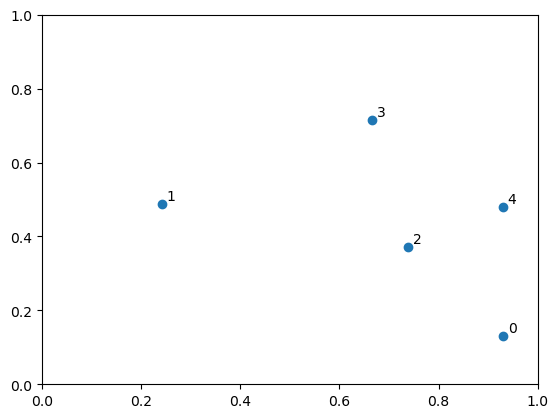

In [166]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
[ax.annotate(i, (p[0]+0.01, p[1]+0.01)) for i, p in enumerate(X)]
ax.scatter(X[:,0], X[:,1])

In [167]:
distances = ((X[np.newaxis, : , :] - X[:, np.newaxis, :])** 2).sum(axis=-1)
np.argsort(distances)

array([[0, 2, 4, 3, 1],
       [1, 3, 2, 4, 0],
       [2, 4, 0, 3, 1],
       [3, 2, 4, 1, 0],
       [4, 2, 0, 3, 1]])